In [2]:
from __future__ import print_function
import pandapower as pp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import stable_baselines
import pickle
from stable_baselines import DDPG
import sys
import copy
sys.path.append('C:\\Users\\vegar\\Dropbox\\Master\\thesis.git')
from  gym_power.envs.active_network_env import ActiveEnv
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook


# I need to see the actions of the agent
The agent activates flexibility to help the net. Need to plot the actions of the agent togeather with solar irradiance and demand at each load.


In [3]:
def find_load_names(sol_bus):
    nr_sol = 1
    nr_else = 1
    load_names = []
    for k in range(len(sol_bus)):
        if sol_bus[k]:
            load_names.append('sun {}'.format(nr_sol))
            nr_sol += 1
        else:
            load_names.append('load {}'.format(nr_else))
            nr_else += 1
    return load_names

In [4]:
def simulate_day2(env,model, show_imbalance=False, show_solar=True, show_action=True,
                  show_demand=False,period=25):
    net = env.powergrid
    sol_bus = net.load['bus'].isin(net.sgen['bus'])
    actions = []
    t_steps = []
    flex_loads = []
    sols = []
    obs = env.reset()
    sol = env.solar_forecasts
    demand = env.demand_forecasts[0]
    names = find_load_names(sol_bus)
    hues = []
    for t_step in range(1,period):
        
        action,_ = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        
        if show_action:
            actions += list(action)
            hues += ['action' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
        
        if show_solar:
            actions += list(sol[t_step-1]*np.ones_like(action))
            hues += ['sun' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
        if show_imbalance:
            try:
                imbalance = env.calc_balance()/30000
            except AttributeError:
                imbalance = env.calc_imbalance()/30000
            actions += list(imbalance*np.ones_like(action))
            hues += ['imbalance' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
            
        if show_demand:
            actions += list(demand[t_step-1]*np.ones_like(action))
            hues += ['demand' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
            


    df = pd.DataFrame()
    df['actions'] = actions
    df['steps'] = t_steps
    df['load'] = flex_loads
    df[''] = hues
    return df

In [5]:
def data_from_subplot(ax, imbalance=False):
    actions = ax.lines[3].get_ydata()
    sun = ax.lines[4].get_ydata()
    balance = ax.lines[5].get_ydata()
    oneplot = pd.DataFrame()
    if imbalance:
        oneplot['Energy imbalance'] = balance
    oneplot['Solar irradiance'] = sun
    oneplot['Action'] = actions
    return oneplot

## Import models

In [22]:
def load_env(model_name='flexible_load_first',seed=9):
#flexible_load_first, overnight, larger_margin_cost, discount_06, flex50

    params_name = model_name +'_params.p'
    model = DDPG.load('models/'+model_name)
    env = ActiveEnv(seed=seed)
    with open('models/' + params_name,'rb') as f:
        params = pickle.load(f)

    env.set_parameters(params)
    model.set_env(env)
    return model, env

In [23]:
model, env = load_env()

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

<IPython.core.display.Javascript object>


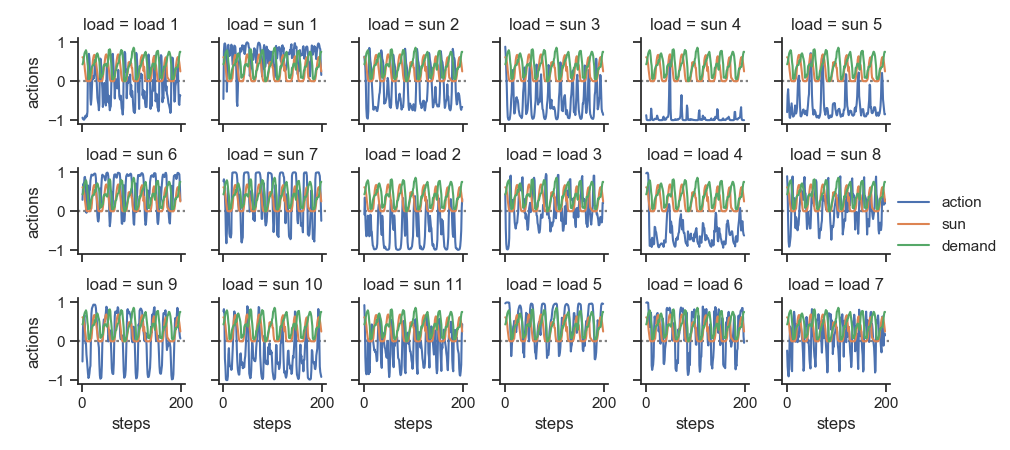

In [24]:
df = simulate_day2(env,model, show_demand=True, period=199)
sns.set(style="ticks")

grid = sns.FacetGrid(df, col="load", hue="",
                     col_wrap=6, height=1.5)

grid.map(plt.axhline, y=0, ls=":", c=".5")

grid.map(plt.plot, "steps", "actions")
grid.add_legend()



In [27]:
env.powergrid.load

,name,bus,p_kw,q_kvar,const_z_percent,const_i_percent,sn_kva,scaling,in_service,type
0,Load R1,1,11130.235669,2346.309447,0.0,0.0,15300.0,1.0,True,None
1,Load R3,3,218.676550,53.943511,0.0,0.0,285.0,1.0,True,None
2,Load R4,4,313.859202,84.227587,0.0,0.0,445.0,1.0,True,None
3,Load R5,5,517.537331,141.956607,0.0,0.0,750.0,1.0,True,None
4,Load R6,6,384.029546,106.940644,0.0,0.0,565.0,1.0,True,None
5,Load R8,8,418.078069,114.511663,0.0,0.0,605.0,1.0,True,None
6,Load R10,10,380.178290,92.744983,0.0,0.0,490.0,1.0,True,None
7,Load R11,11,250.476477,64.353662,0.0,0.0,340.0,1.0,True,None
8,Load R12,12,11919.536178,2346.309447,0.0,0.0,15300.0,1.0,True,None
9,Load R14,14,165.839170,40.694227,0.0,0.0,215.0,1.0,True,None


In [29]:
@interact
def plot_load(ax_nr1=range(18),ax_nr2=range(18),period=(0,200)):
    plot1 = data_from_subplot(grid.axes[ax_nr1],imbalance=True)
    plot2 = data_from_subplot(grid.axes[ax_nr2],imbalance=True)

    fig, axes = plt.subplots(2)
    #axes.set_title(ax.get_title())
    #axes.set_title('Total energy imbalance')
    axes[0].set_xlabel('steps')
    axes[0].axhline(0,c=".5",ls='--')
    axes[1].axhline(0,c=".5",ls='--')
    #axes.set_ylabel('MWh')
    plot1[:period].plot(ax=axes[0])
    plot2[:period].plot(ax=axes[1])
    plt.tight_layout()


interactive(children=(Dropdown(description='ax_nr1', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

In [30]:
env.powergrid.load

,name,bus,p_kw,q_kvar,const_z_percent,const_i_percent,sn_kva,scaling,in_service,type
0,Load R1,1,11130.235669,2346.309447,0.0,0.0,15300.0,1.0,True,None
1,Load R3,3,218.676550,53.943511,0.0,0.0,285.0,1.0,True,None
2,Load R4,4,313.859202,84.227587,0.0,0.0,445.0,1.0,True,None
3,Load R5,5,517.537331,141.956607,0.0,0.0,750.0,1.0,True,None
4,Load R6,6,384.029546,106.940644,0.0,0.0,565.0,1.0,True,None
5,Load R8,8,418.078069,114.511663,0.0,0.0,605.0,1.0,True,None
6,Load R10,10,380.178290,92.744983,0.0,0.0,490.0,1.0,True,None
7,Load R11,11,250.476477,64.353662,0.0,0.0,340.0,1.0,True,None
8,Load R12,12,11919.536178,2346.309447,0.0,0.0,15300.0,1.0,True,None
9,Load R14,14,165.839170,40.694227,0.0,0.0,215.0,1.0,True,None


In [177]:
sol_bus = net.load['bus'].isin(net.sgen['bus'])

## See resulting voltages etc

In [42]:
env.powergrid.res_bus

,vm_pu,va_degree,p_kw,q_kvar
0,1.030000,0.000000,-29900.456517,-9086.961999
1,1.009357,-3.664185,11333.733241,2933.480999
2,0.996422,-4.237402,0.000000,0.000000
3,0.975807,-5.144488,330.646468,144.530961
4,0.974814,-5.196491,322.639727,68.400152
5,0.974195,-5.227244,361.806933,115.281155
6,0.973481,-5.262905,262.167977,86.845137
7,0.972465,-5.277896,63.411203,34.208192
8,0.972660,-5.268847,385.352659,92.993465
9,0.972120,-5.286005,311.028317,256.561444


In [83]:
period=199
show_action = True
net = env.powergrid
actions = []
t_steps = []
flex_loads = []
obs = env.reset()
sol = env.solar_forecast
hues = []
env.set_parameters({'flexibility':0.25,
                   'solar_scale':1.2})
env2 = copy.deepcopy(env)
env2.do_action = False

for t_step in range(1,period):

    #action,_ = model.predict(obs)
    action2 = -np.ones(18)
    obs1, rewards1, dones1, info1 = env.step(action2)
    
    obs2, rewards2, dones2, info2 = env2.step(action2)
    
    #if env.powergrid.res_bus.vm_pu.max() > 1.05:
    #    break
    v_agent = env.powergrid.res_bus.vm_pu
    actions += list(v_agent)
    hues += ['-25% demand' for _ in range(len(v_agent))]
    t_steps += list(t_step*np.ones_like(v_agent))
    flex_loads += list(range(len(v_agent)))
    
    
    v_no_action = env2.powergrid.res_bus.vm_pu
    actions += list(v_no_action)
    hues += ['No agent' for _ in range(len(v_no_action))]
    t_steps += list(t_step*np.ones_like(v_no_action))
    flex_loads += list(range(len(v_agent)))

df = pd.DataFrame()
df['Voltage [pu]'] = actions
df['Hours'] = t_steps
df['Load'] = flex_loads
df[''] = hues

<IPython.core.display.Javascript object>


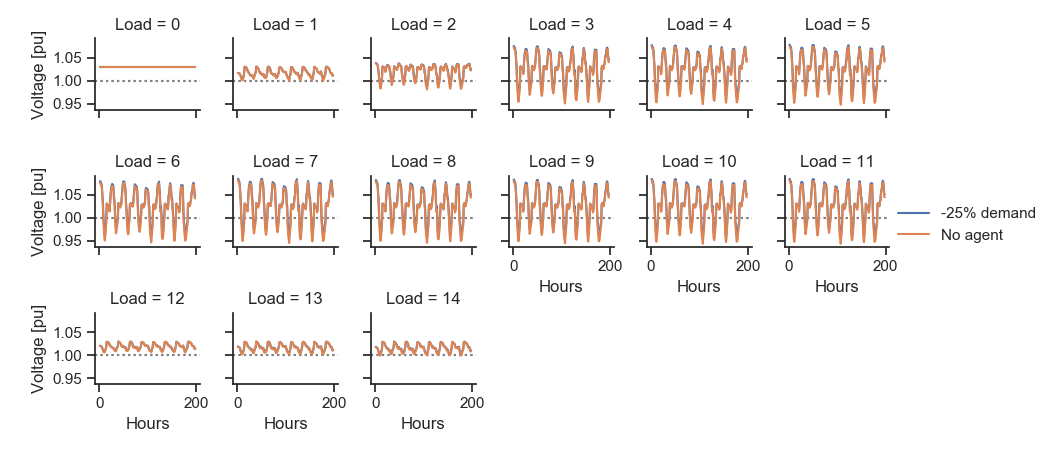

In [84]:
sns.set(style="ticks")
grid = sns.FacetGrid(df, col="Load", hue="",
                     col_wrap=6, height=1.5)


grid.map(plt.axhline, y=1, ls=":", c=".5")

grid.map(plt.plot, "Hours", "Voltage [pu]")
grid.add_legend()



In [82]:
@interact
def plot_voltage(bus_nr=list(range(15))[::-1]):
    data = df[df['Load']== bus_nr]
    fig, ax = plt.subplots()
    sns.lineplot(x="Hours", y="Voltage [pu]", data=data, ax=ax, hue='')
    


interactive(children=(Dropdown(description='bus_nr', options=(14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0…

In [105]:
def change_hours(x,start=155):
    return x-start
def change_legend(x):
    if x == 'No agent':
        return 'No action'
    else:
        return x

<IPython.core.display.Javascript object>


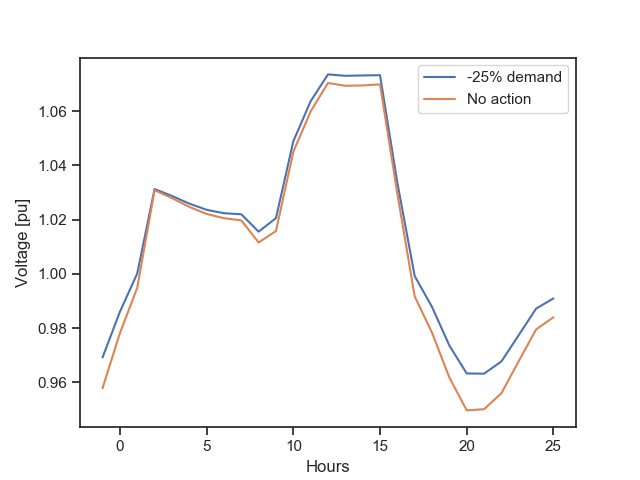

In [106]:
data = df[df['Load']== 8]
data = data[data['Hours'].isin(range(156,183))]
data[''] = data[''].apply(lambda x:change_legend(x))
data['Hours'] = data['Hours'].apply(lambda x:change_hours(x,start=157))
fig, ax = plt.subplots()
sns.lineplot(x="Hours", y="Voltage [pu]", data=data, ax=ax, hue='')

In [107]:
#fig.savefig('figs/decrease_demand_voltage.png')

## Line capacity effect

In [113]:
period=199
show_action = True
net = env.powergrid
actions = []
t_steps = []
flex_loads = []
obs = env.reset()
hues = []
env.set_parameters({'solar_scale': 1.2,
                    'flexibility':0.25})
env2 = copy.deepcopy(env)
env2.do_action = False



for t_step in range(1,period):

    action,_ = model.predict(obs)
    action2 = np.ones(18)
    action2[0] = -1

    obs1, rewards1, dones1, info1 = env.step(action2)
    obs2, rewards2, dones2, info2 = env2.step(action2)
    
    
    i_agent = env.powergrid.res_line['loading_percent']
    actions += list(i_agent)
    hues += ['+ 25 % demand' for _ in range(len(i_agent))]
    t_steps += list(t_step*np.ones_like(i_agent))
    flex_loads += list(range(len(i_agent)))
    
    
    i_no_agent = env2.powergrid.res_line['loading_percent']
    actions += list(i_no_agent)
    hues += ['No actions' for _ in range(len(i_no_agent))]
    t_steps += list(t_step*np.ones_like(i_no_agent))
    flex_loads += list(range(len(i_no_agent)))

df = pd.DataFrame()
df['Line capacity [%]'] = actions
df['Hours'] = t_steps
df['Line'] = flex_loads
df[''] = hues

<IPython.core.display.Javascript object>


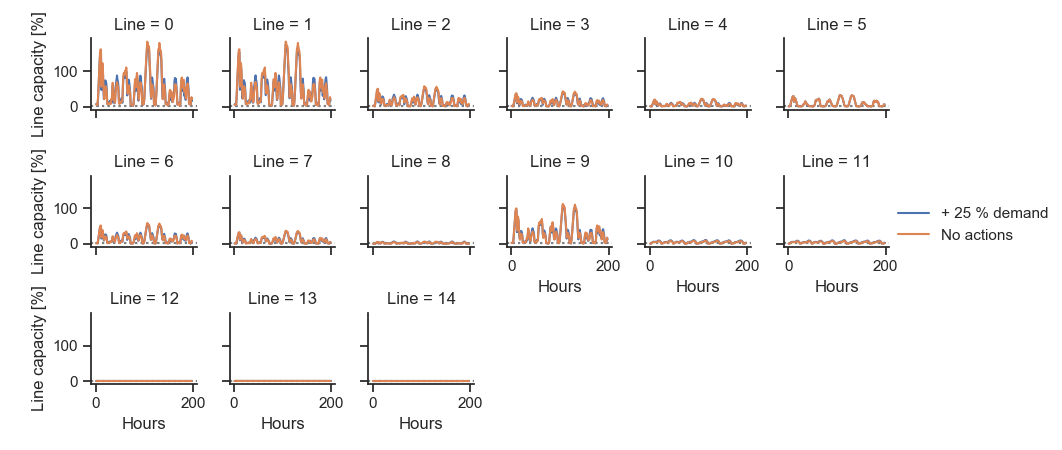

In [114]:
sns.set(style="ticks")
grid = sns.FacetGrid(df, col="Line", hue="",
                     col_wrap=6, height=1.5)


grid.map(plt.axhline, y=1, ls=":", c=".5")

grid.map(plt.plot, "Hours", "Line capacity [%]")
grid.add_legend()



In [115]:
@interact
def plot_current(bus_nr=list(range(15))):
    data = df[df['Line']== bus_nr]
    fig, ax = plt.subplots()
    sns.lineplot(x="Hours", y="Line capacity [%]", data=data, ax=ax, hue='')
    


interactive(children=(Dropdown(description='bus_nr', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

<IPython.core.display.Javascript object>


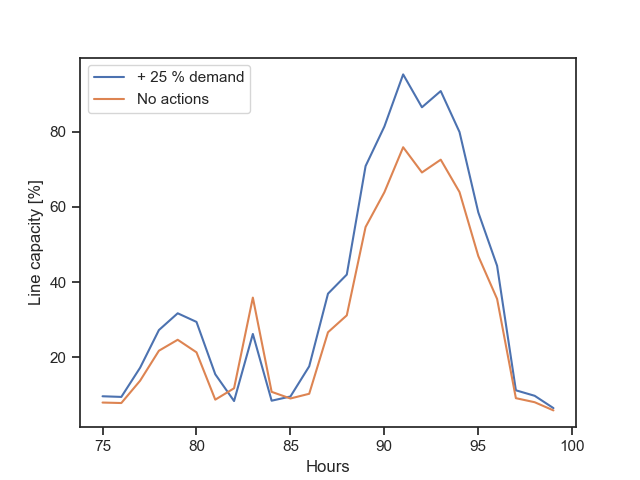

In [17]:
data = df[df['Line']== 0]
data = data[data['Hours'].isin(range(75,100))]
fig, ax = plt.subplots()
sns.lineplot(x="Hours", y="Line capacity [%]", data=data, ax=ax, hue='')
#fig.savefig('increase_demand_current.png')

In [56]:
env.powergrid.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,Line 1-2,CABLE_CIGRE_MV,1,2,2.82,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
1,Line 2-3,CABLE_CIGRE_MV,2,3,4.42,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
2,Line 3-4,CABLE_CIGRE_MV,3,4,0.61,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
3,Line 4-5,CABLE_CIGRE_MV,4,5,0.56,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
4,Line 5-6,CABLE_CIGRE_MV,5,6,1.54,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
5,Line 7-8,CABLE_CIGRE_MV,7,8,1.67,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
6,Line 8-9,CABLE_CIGRE_MV,8,9,0.32,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
7,Line 9-10,CABLE_CIGRE_MV,9,10,0.77,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
8,Line 10-11,CABLE_CIGRE_MV,10,11,0.33,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
9,Line 3-8,CABLE_CIGRE_MV,3,8,1.30,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True


## See the difference in reward between agent and no-agent

In [42]:
period=199
net = env.powergrid
rewards = []
t_steps = []
flex_loads = []
obs = env.reset()
hues = []
env2 = copy.deepcopy(env)
env2.do_action = False
sol = env.get_episode_solar_forecast()
demand = env.get_episode_demand_forecast()[0]

show_sun = False
show_demand = False
for t_step in range(1,period):

    action,_ = model.predict(obs)
    obs1, reward1, dones1, info1 = env.step(action)
    obs2, reward2, dones2, info2 = env2.step(action)
    
    
    rewards.append(reward1)
    hues.append('Agent')
    t_steps.append(t_step)
    
    rewards.append(reward2)
    hues.append('No agent')
    t_steps.append(t_step)
    
    if show_sun:    
        rewards.append(sol[t_step-1])
        hues.append('Sun')
        t_steps.append(t_step)
        
    if show_demand:
        rewards.append(demand[t_step-1])
        hues.append('Demand')
        t_steps.append(t_step)

df = pd.DataFrame()
df['Reward'] = rewards
df['Steps'] = t_steps
df[''] = hues

In [21]:
env.params

{'activation_weight': 0.0001,
 'current_weight': 0.01,
 'demand_scale': 10,
 'episode_length': 200,
 'flexibility': 0.5,
 'forecast_horizon': 4,
 'i_upper': 90,
 'imbalance_weight': 0.0001,
 'reward_terms': ['voltage', 'current', 'imbalance'],
 'solar_scale': 0.8,
 'state_space': ['sun', 'demand', 'imbalance'],
 'v_lower': 0.96,
 'v_upper': 1.04,
 'voltage_weight': 1}

<IPython.core.display.Javascript object>


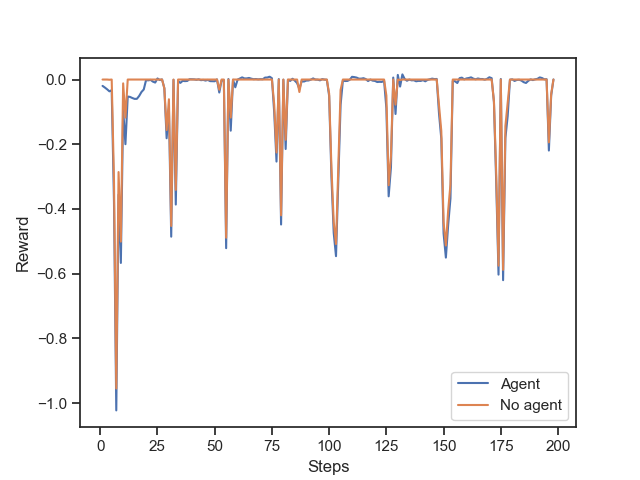

In [43]:
fig,ax = plt.subplots()
sns.lineplot(x='Steps',y='Reward',data=df,hue='', ax=ax)

In [44]:
df[df[''] == 'Agent'].describe()

,Reward,Steps
count,198.000000,198.000000
mean,-0.066110,99.500000
std,0.154564,57.301832
min,-1.022731,1.000000
25%,-0.032387,50.250000
50%,-0.002953,99.500000
75%,0.001001,148.750000
max,0.015886,198.000000


In [45]:
df[df[''] == 'No agent'].describe()

,Reward,Steps
count,198.000000,198.000000
mean,-0.055413,99.500000
std,0.142280,57.301832
min,-0.954919,1.000000
25%,-0.000000,50.250000
50%,-0.000000,99.500000
75%,-0.000000,148.750000
max,-0.000000,198.000000


## Exponential stuff

In [117]:
time = []
gammas = []
values = []
for gamma in np.linspace(0.1,1,10):
    for i in range(1,10):
        gammas.append(gamma)
        values.append(gamma**i)
        time.append(i)
        
df = pd.DataFrame()
df['time'] = time
df['gamma'] = gammas
df['values'] = values


<IPython.core.display.Javascript object>


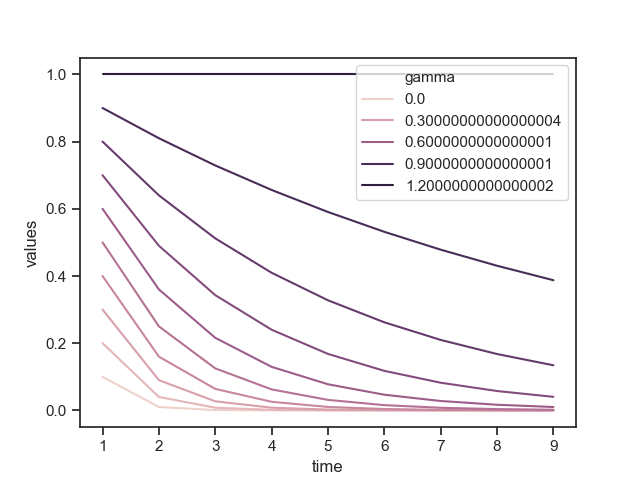

In [118]:
fig,ax = plt.subplots()
sns.lineplot(x='time', y='values',hue='gamma',data=df)
